# 224 Object Detection
This notebook uses yolo-v4-tiny-tf or yolo-v4-tf as an example for yolo like object detection using the OpenVINO toolkit. A YouTube video is downloaded and used to show the results of the detections.

In [ ]:
from openvino.runtime import Core

from pytube import YouTube
import cv2
import numpy as np
from IPython import display

import os
from collections import deque
import time

## Download Inference Video
Pytube is used to download a traffic intersection video from youtube. Feel free to change the link to whichever video you like. Keep in mind long videos may take some time.

In [ ]:
link = "https://www.youtube.com/watch?v=jjlBnrzSGjc"

video = YouTube(link)

path = os.path.join(os.getcwd(), "utils")
os.makedirs(path, exist_ok=True)

existing_videos = [title[:-4] for title in os.listdir(path)]
if not video.title in existing_videos:
    print("Downloading video...")
    video.streams.filter(file_extension="mp4", res="720p").first().download(
        output_path=path
    )
video_file = f"{video.title}.mp4"


## Download Model
Omz downloader is a tool created by OpenVINO to download its premade models. <br>
You can select either yolo v4 tiny as 'yolo-v4-tiny-tf' or yolo v4 as 'yolo-v4-tf'. Other models have not been tested with this notebook.<br>
Yolo v4 will have better detection quality than Yolo v4 tiny at the cost of latency. You will be able to see that Yolo v4 performs much better than Yolo v4 tiny, specifically with smaller objects, because it has an extra output layer with higher resolution and smaller anchors sizes.

In [ ]:
model_name = 'yolo-v4-tiny-tf'
#model_name = 'yolo-v4-tf'

download_command = f'omz_downloader ' \
                   f'--name {model_name} ' \
                   f'--output_dir {path} ' \
                   f'--cache_dir {path}'

! $download_command

## Convert Model
Here we convert to FP16. You can also try FP32 but will have increased inference time.

In [ ]:
precision = 'FP16'

# output path for the conversion
converted_model_path = f'public/{model_name}/{precision}/{model_name}.xml'
full_converted_path = os.path.join(path, converted_model_path)

if not os.path.exists(full_converted_path):
    convert_command = f'omz_converter ' \
                      f'--name {model_name} ' \
                      f'--download_dir {path} ' \
                      f'--precisions {precision}'
    ! $convert_command

### Loading the model
Loads the converted model with path based on precision and model name. <br>
Using the input layer we can get the width and height of the model input, which, in the case with Yolo v4 is 416 x 416 pixels. <br>

Following that, each of the output layers are retreived. Yolov4 uses a PANET architecture with multi-size output layers to help with detecting objects of variable sizes. In this notebook we put the layers in ascending order based on the size of the output layer. Or more specifically, ascending based on the amount of detection cells the output layer has. <br>

Smaller output layers feature larger detections, such as big or close up objects, while the higher resolution output layers, are meant to detect smaller or farther away objects.

In [ ]:
ie = Core()
model = ie.read_model(model=full_converted_path)
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer = compiled_model.input(0)

# height and width of inputs
height = input_layer.shape[1]
width = input_layer.shape[2]

# Yolov4 uses PAnet, resulting in multiple detection layers
# make sure to use .output(layer) because .outputs
# doesn't maintain order
outputs = []
for layer in range(len(compiled_model.outputs)):
    outputs.append(compiled_model.output(layer))

# incorrect layer output order work around
if model_name == "yolo-v4-tf":
    # orig layer size order 36, 19, 76
    # change to order 19, 36, 76 to fit anchors order
    temp = outputs[0]
    outputs[0] = outputs[1]
    outputs[1] = temp

# view outputs shapes
for layer in outputs:
    print(layer.shape)


## Model Data
Anchors dict stores the anchors of both the yolov4 and the yolov4 tiny models. Changing the model name will change the anchors that are used.
Yolov4 uses 3 output layers and yolov4 tiny uses 2 output layers for a total of 9 and 6 anchors respectively.
Classes corrospond with coco the coco 80 dataset. <br>
You can see as mentioned above, that yolov4 contains a larger variety of anchors to assist it with detecting a larger variety of object sizes.

In [ ]:
anchors_dict = {
    "yolo-v4-tiny-tf": [
        [[81, 82], [135, 169], [344, 319]],
        [[23, 27], [37, 58], [81, 82]],
    ],
    "yolo-v4-tf": [
        [[142, 110], [192, 243], [459, 401]],
        [[36, 75], [76, 55], [72, 146]],
        [[12, 16], [19, 36], [40, 28]],
    ],
}
anchors = anchors_dict[model_name]

# https://github.com/Tianxiaomo/pytorch-YOLOv4/blob/master/DeepStream/labels.txt
classes = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 
    'boat', 'trafficlight', 'firehydrant', 'stopsign', 'parkingmeter', 'bench', 'bird', 
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 
    'sportsball', 'kite', 'baseballbat', 'baseballglove', 'skateboard', 'surfboard', 
    'tennisracket', 'bottle', 'wineglass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 
    'donut', 'cake', 'chair', 'couch', 'pottedplant', 'bed', 'diningtable', 'toilet', 
    'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cellphone', 'microwave', 'oven', 
    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
    'teddybear', 'hairdrier', 'toothbrush'
]

# colors for above classes (Rainbow Color Map)
colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(classes), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()
np.random.shuffle(colors)


# Model Output
Yolo has quite a bit of post processing that must be done to the output in order to generate bounding boxes with (x1, y1) and (x2, y2) coordinates.
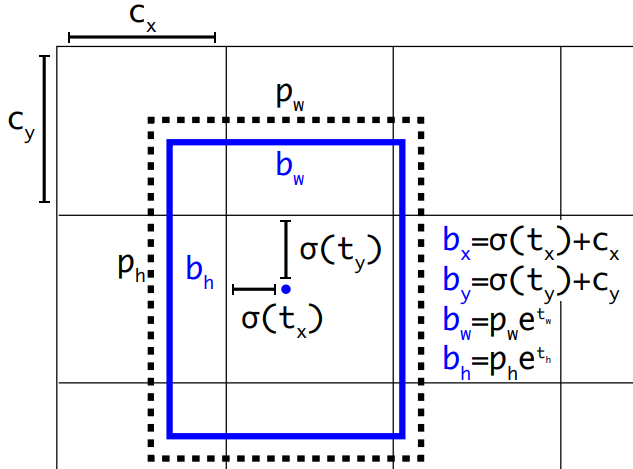 <br>
The shape of the output is B, Cy, Cx, 255. Since each output layer has 3 anchors, 85 indices of the last dimension are allocated per anchor. <br>
index: <br>
* 0 : x offset
* 1 : y offset
* 2 : box width
* 3 : box height 
* 4-84 : Object Probability</ul>
Each of these values are in their raw format.
Following the picture above we take ${sigmoid}({xoffset})$ + Cx.
Next we divide by the width of the output to make the range: \[0, 1\] and multiply by the width of the input to get the center x location of the bounding box in terms of intput size -- range: \[0, 416\]. <br>
This same operation is then applied to the y axis with y offset, Cy, output width and input width.
<br><br>
Since each detection cell in the output actually contains 3 total detections, with each corrosponding to an anchor, we apply this set of operations three times total per cell.
This is why we do <br> ```range(0, 255, 85)``` <br>
Because 85 indices correspond to one anchor, we increment by 85 to reach the next detection. These anchors are critical to finding the width and height of the bounding boxes. $e^{box width} * anchor[i][0]$ is used to find the true box width in terms of the input resolution. Box height formula is $e^{box height} * anchor[i][1]$
<br><br>
Yolo models produce lots of output bounding boxes. <br>Score thresholding excludes the majority of the bounding boxes and helps with eliminated calculation append operations. NMS is also applied to remove overlapping boxes. Algorithm can be further optimized to include large batchsize and vectorized operations.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def process_results(results, thresh=0.5):
    # size of the original frame
    boxes = []
    labels = []
    scores = []
    # results is a list of tensors. Each being one output layer
    for layer, output in enumerate(results):
        for cell_y, col in enumerate(output):
            for cell_x, grid in enumerate(col):
                for anchor_idx, base_idx in enumerate(range(0, 255, 85)):
                    if sigmoid(grid[base_idx + 4]) > thresh:
                        # Calculate both center x and center y
                        offset_x = sigmoid(grid[base_idx])
                        offset_y = sigmoid(grid[base_idx + 1])
                        center_x = cell_x + offset_x
                        center_x *= width / output.shape[1]
                        center_y = cell_y + offset_y
                        center_y *= height / output.shape[0]

                        # Calculate the width and height of the boxes
                        box_width = np.exp(grid[base_idx + 2])
                        box_width *= anchors[layer][anchor_idx][0]
                        box_height = np.exp(grid[base_idx + 3])
                        box_height *= anchors[layer][anchor_idx][1]

                        # Find left and top for cv2 NMS
                        left = center_x - box_width / 2
                        top = center_y - box_height / 2

                        # Save bounding boxes and relevant data
                        boxes.append((left, top, box_width, box_height))
                        scores.append(sigmoid(grid[base_idx + 4]))
                        labels.append(np.argmax(grid[base_idx + 5 : base_idx + 85]))

    # apply non-maximum suppression to get rid of many overlapping entities
    # see https://paperswithcode.com/method/non-maximum-suppression
    # this algorithm returns indices of objects to keep
    # boxes is list of (left, top, box width, box height)
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes, scores=scores, score_threshold=thresh, nms_threshold=0.6
    )

    # if there are no boxes
    if len(indices) == 0:
        return []

    # filter detected objects
    return [(labels[idx], scores[idx], boxes[idx]) for idx in indices.flatten()]


### Helper methods
Preserved resize takes the initial image and resizes it to fit the input size. This one specifically preserves the aspect ratio of the image to improve inference quality. 

In [ ]:
def draw_boxes(frame, boxes, dsize):
    frame_h, frame_w = frame.shape[0:2]
    for label, score, box in boxes:
        # choose color for the label
        color = tuple(map(int, colors[label]))
        # establish xy coords for box corners
        # divide by the factor to reverse the scaling
        factor = min(dsize[0] / frame.shape[0], dsize[1] / frame.shape[1])
        x1 = int(box[0] / factor)
        y1 = int(box[1] / factor)
        w = int(box[2] / factor)
        h = int(box[3] / factor)
        x2 = x1 + w
        y2 = y1 + h
        cv2.rectangle(img=frame, pt1=(x1, y1), pt2=(x2, y2), color=color, thickness=3)
        # draw label name inside the box
        cv2.putText(
            img=frame,
            text=f"{classes[label]} {score:.2f}",
            org=(x1, y1 - 3),
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            fontScale=frame_w / 1500,
            color=color,
            thickness=1,
            lineType=cv2.LINE_AA,
        )

    return frame


# modded from:
# https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
# https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
def preserved_resize(frame, dsize, interpolation=cv2.INTER_AREA):
    # find the smallest resize ratio. this is how much we need to scale the image.
    factor = min(dsize[0] / frame.shape[0], dsize[1] / frame.shape[1])
    height = int(frame.shape[0] * factor)
    width = int(frame.shape[1] * factor)
    frame = cv2.resize(src=frame, dsize=(width, height), interpolation=interpolation)

    # pad image
    dh = dsize[0] - height
    dw = dsize[1] - width

    color = [127, 127, 127]  # grey pad
    # only pad the right and bottom so bounding box is easier to scale later
    frame = cv2.copyMakeBorder(frame, 0, dh, 0, dw, cv2.BORDER_CONSTANT, value=color)
    return frame


In [ ]:
# main processing function to run object detection
def run_object_detection(source=False, use_popup=False, save=False):
    player = None
    try:
        # create video player to play with target fps
        if source:
            player = cv2.VideoCapture(source)
        else:
            player = cv2.VideoCapture(os.path.join(path, video_file))
        # start capturing
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )
        elif save:
            w = int(player.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(player.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fourcc = cv2.VideoWriter_fourcc(*"MP4V")
            writer = cv2.VideoWriter(save, fourcc, 30, (w, h))
            frame_count = 0

        processing_times = deque()
        while True:
            # youtube is 30fps. Begin counting time.
            frame_start = time.time()

            # grab the frame
            ret, frame = player.read()
            if not ret:
                print("Source ended or error finding video")
                break

            # resize image and change dims to fit neural network input
            input_img = preserved_resize(
                frame, dsize=(height, width), interpolation=cv2.INTER_AREA
            )
            # create batch of images (size = 1)
            input_img = input_img[np.newaxis, ...]

            # measure processing time
            start_time = time.time()
            # get results. OpenVINO, as with cv2, uses BGR not RGB
            results = compiled_model([input_img])
            # change results from dict to list which each output being the index
            # we can squeeze because batch size is only 1
            results = [results[layer].squeeze() for layer in outputs]
            stop_time = time.time()
            # get poses from network results
            boxes = process_results(results=results)

            # draw boxes on a frame
            frame = draw_boxes(frame=frame, boxes=boxes, dsize=(width, height))

            processing_times.append(stop_time - start_time)
            # use processing times from last 200 frames
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            # use this workaround if there is flickering
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            elif save:
                frame_count += 1
                print(
                    f"Current frame: {frame_count}, Inference time: {processing_time:0.1f}ms",
                    end="\r",
                )
                writer.write(frame)
            else:
                # encode numpy array to jpg
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # create IPython image
                i = display.Image(data=encoded_img)
                # display the image in this notebook
                display.clear_output(wait=True)
                display.display(i)

            # finish counting the time.
            # sleep till 30fps
            dt = 1 / 30 - (time.time() - frame_start)
            if dt > 0 and not save:
                time.sleep(dt)

    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # stop capturing
            player.release()
        if save:
            writer.release()
        if use_popup:
            cv2.destroyAllWindows()


# Run detection
There are multiple options when running detection. When running Yolo v4 tiny it is possible to run it in real time with the first option, but if you are using yolo v4 it is recommended to run detection with the second line to save the output since it probably will not be able to run in real time on cpu. <br><br>
Inference video will still save if prematurely interrupted.

In [ ]:
run_object_detection(source=False, use_popup=False, save=False)
# run_object_detection(source=False, use_popup=False, save='output.mp4')


### Refrences
1. [Yolo v4 paper](https://arxiv.org/pdf/2004.10934.pdf)
2. [Yolo v4 tiny](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/yolo-v4-tiny-tf)
3. [Yolo v4](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/yolo-v4-tf)
4. [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/)
5. [Non-Maximum Suppression](https://paperswithcode.com/method/non-maximum-suppression)
6. 401-object-detection (/../401-object-detection)
